In [89]:
import numpy as np
import pandas as pd
import re
import json

# Import skygrid client

In [90]:
import time

from disneylandClient import (
    new_client,
    Job,
    RequestWithId,
)

STATUS_IN_PROCESS = set([
    Job.PENDING,
    Job.PULLED,
    Job.RUNNING,
])
STATUS_FINAL = set([
    Job.COMPLETED,
    Job.FAILED,
])

def return_descriptor(f_name, n_iteration=50, n_attempts=5, dims=2, low_f=25, high_f=50, bound=1):
    
    initial_size = 2 * dims + 3
    
    cmd = "python /opt/script.py --f_name "+f_name+" --n_iteration="+str(n_iteration)+" --n_attempts="+str(n_attempts)+\
          " --low_f="+str(low_f)+" --high_f="+str(high_f)+" --dims="+str(dims)+" --initial_size="+str(initial_size)+\
          " --bound="+str(bound)

    descriptor = {
        "input": [],

        "container": {
            "workdir": "",
            "name": "oleg94/optimization_runner2",
            "cpu_needed": 4,
            "max_memoryMB": 4096,
            "min_memoryMB": 2048,
            "cmd": cmd,
        },

        "required_outputs": {
            "output_uri": "none:",
            "file_contents": [
                {"file": "output.txt", "to_variable": "out"}
            ]
        }
    }
    
    return descriptor

# Send tasks

In [91]:
stub = new_client()
jobs = {}

In [93]:
for f_name, bound in [('ackley1', 1), ('michalewicz', 2), ('rosenbrock', 100)]:
    for dims in [2, 5, 7]:
        for low_f, high_f in [(5, 10), (5, 25), (10, 25), (100, 200), (100, 500), (50, 100)]:
            descriptor = return_descriptor(f_name, bound=bound, dims=dims, low_f=low_f, high_f=high_f)
            key = f_name+"_"+str(bound)+"_"+str(dims)+"_"+str(low_f)+"_"+str(high_f)
            jobs[key] = Job(input=json.dumps(descriptor), kind="docker")
            jobs[key] = stub.CreateJob(jobs[key])

# Get results

In [ ]:
for k in jobs.keys():
    jobs[k] = stub.GetJob(RequestWithId(id=jobs[k].id))

for k in jobs.keys():
    if jobs[k].status == Job.COMPLETED:
        print(k, ": finished")
    elif jobs[k].status == Job.PENDING:
        print(k, ": pending")
    elif jobs[k].status == Job.PULLED:
        print(k, ": pulled")
    elif jobs[k].status == Job.RUNNING:
        print(k, ": running")
    else:
        print(k, ": failed")

In [8]:
for key in jobs.keys():
    if key:
        if jobs[key].status == Job.COMPLETED:
            output = json.loads(re.sub(r"\\", '', jobs[key].output[15:-2]))
            with open('skygrid_results_new_2/'+key+'.txt', 'w') as f:
                json.dump(output, f)

In [129]:
output = json.loads(re.sub(r"\\", '', jobs['michalewicz_2_2_10_25'].output[15:-2]))

In [130]:
agg = np.array(output)
for i in range(len(agg)):
    for j in range(len(agg[i])):
        for k in range(len(agg[i,j])):
            agg[i,j,k] = np.array(agg[i,j,k])

In [131]:
def return_track(agg, objective, type_track='true'):
    
    tracks = []
    
    if type_track=='true':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                argmins = agg[i, j, 1][agg[i, j, 4]]
                values = objective(argmins)
                subtracks.append(values)
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)
        
            
    
    elif type_track=='noisy':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                subtracks.append(np.minimum.accumulate(agg[i, j, 2] / agg[i, j, 3]))
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)

In [132]:
import numpy as np
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from functionDoESpecial import functionDoESpecial, function_dimensions, function_names
from binomial_optimization2 import optimization_step, value_generator

bound = 2
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), 'michalewicz')
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, 'michalewicz') * 0.95 - min_v) / (max_v - min_v)

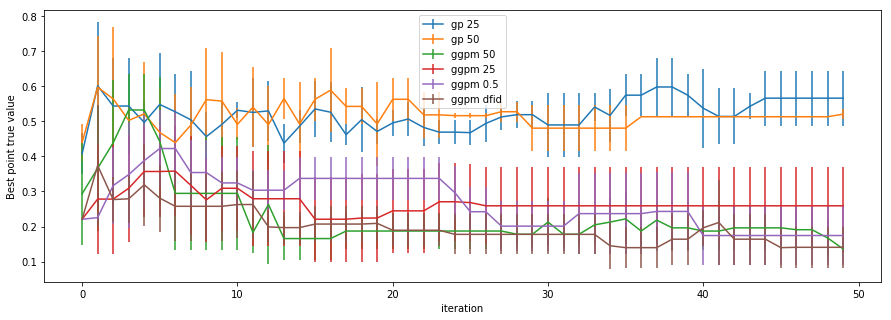

In [133]:
means, stds = return_track(agg, objective)

plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp 25')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='gp 50')
plt.errorbar(np.arange(len(means[2])),  means[2], yerr=stds[2], label='ggpm 50')
plt.errorbar(np.arange(len(means[3])),  means[3], yerr=stds[3], label='ggpm 25')
plt.errorbar(np.arange(len(means[4])),  means[4], yerr=stds[4], label='ggpm 0.5')
plt.errorbar(np.arange(len(means[5])),  means[5], yerr=stds[5], label='ggpm dfid')
# plt.yscale('log', nonposy='clip')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

[-0.00679571]


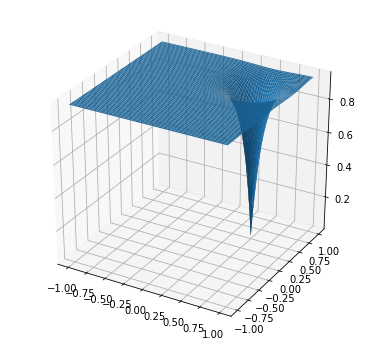

In [60]:
xs = np.linspace(-bound, bound, 300)
ys = np.linspace(-bound, bound, 300)
xs, ys = np.meshgrid(xs, ys)
values = objective(np.dstack([xs, ys]).reshape(90000, 2)).reshape(300, 300)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)
print(objective(argmin.reshape(1, -1)))

In [144]:
agg[0, 0, 1][agg[0, 0, 4][5]]

array([-15.26603264,  -0.98100544,  21.18886462, -76.82002005,
        82.87664782])